In [51]:
import scipy.io
import pandas as pd


mat_data = scipy.io.loadmat('Acute_Leukemia.mat')

# features = fea, ground truth = gnd

data = mat_data['fea']
gnd_data = mat_data['gnd']


df = pd.DataFrame(data)

print(df.shape)


(2096, 54675)


In [52]:
print(gnd_data.shape, df.shape)
labels = pd.DataFrame(gnd_data)
labels = labels.rename(columns={labels.columns[0]: "label"})


(2096, 1) (2096, 54675)


In [53]:
df_labeled = pd.concat([df, labels], axis=1, sort=False)
# display(df_labeled.head(20))


In [54]:

import pandas as pd


print(df_labeled.columns)

X = df_labeled.iloc[:, :-1]  # Use integer-based indexing

y = df_labeled.iloc[:, -1]  # Use integer-based indexing

print("X shape:", X.shape)
print("y shape:", y.shape)


Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,
       ...
         54666,   54667,   54668,   54669,   54670,   54671,   54672,   54673,
         54674, 'label'],
      dtype='object', length=54676)
X shape: (2096, 54675)
y shape: (2096,)


In [72]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
import numpy as np

# Load the data matrix into a NumPy array

data = X

# Select the 16384 most important features based on mutual information
selector = SelectKBest(mutual_info_regression, k=16384)
selected_data = selector.fit_transform(data, labels)

# Print the new shape of the data matrix
# print(selected_data.shape)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [73]:
from sklearn.model_selection import train_test_split
import numpy as np

# X = X[:,:-52]
# print(X.shape)


X_train, X_test, y_train, y_test = train_test_split(
    selected_data, y, test_size=0.2, random_state=42)
# X_train.reset_index()
# X_test.reset_index()


print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (1676, 16384)
X_test shape: (420, 16384)
y_train shape: (1676,)
y_test shape: (420,)


In [74]:
X_train


array([[0.56033629, 0.4515214 , 0.70154345, ..., 0.85718828, 0.8188526 ,
        0.83263701],
       [0.23435177, 0.44928321, 0.57999158, ..., 0.91857702, 0.86384368,
        0.88075286],
       [0.3366814 , 0.30190688, 0.64329654, ..., 0.84214413, 0.7413078 ,
        0.78981537],
       ...,
       [0.27044594, 0.52521038, 0.67164266, ..., 0.91183209, 0.88841873,
        0.87652594],
       [0.56756926, 0.38600078, 0.50377303, ..., 0.83231664, 0.75521874,
        0.78045702],
       [0.27484381, 0.52676755, 0.6205796 , ..., 0.87014413, 0.82795197,
        0.84677607]])

In [75]:
import torch
import torch.nn as nn


X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
Y_train = torch.tensor(y_train.values)
Y_test = torch.tensor(y_test.values)


In [76]:
torch.save(X_train, 'X_train_n.pt')
torch.save(X_test, 'X_test_n.pt')
torch.save(Y_train, 'Y_train_n.pt')
torch.save(Y_test, 'Y_test_n.pt')


In [77]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset


In [78]:
X_train = torch.load('X_train_n.pt').float()
X_test = torch.load('X_test_n.pt').float()
y_train = torch.load('Y_train_n.pt').long()
y_test = torch.load('Y_test_n.pt').long()


In [79]:
# To numericaly index the labels starting from zero instead of one
y_train = y_train - 1
y_test = y_test - 1


In [80]:
X_train.shape


torch.Size([1676, 16384])

In [82]:
# convert X_train of size 1676 ,16384 into 1676 x 1 x 128 x 128

X_train = X_train.reshape(1676, 1, 128, 128)
X_test = X_test.reshape(420, 1, 128, 128)


In [83]:
# dataloaders

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32,
                          shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=1,
                         shuffle=True, drop_last=True)


In [96]:
class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, padding=1, kernel_size=5, stride=1)
        self.batchnorm1 = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 32, padding=1,  kernel_size=5, stride=1)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, padding=1, kernel_size=5, stride=1)
        self.batchnorm3 = nn.BatchNorm2d(64)
        # self.conv4 = nn.Conv2d(64, 128, padding=1, kernel_size=5, stride=1)
        # self.batchnorm4 = nn.BatchNorm2d(128)
        self.expectedsize = 64*14*14
        self.fc1 = nn.Linear(self.expectedsize, 36)
        self.fc2 = nn.Linear(36, 18)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = self.batchnorm1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.max_pool2d(x, 2)
        x = self.batchnorm3(x)
        x = F.relu(x)
        # x = self.conv4(x)
        # x = F.max_pool2d(x, 2)
        # x = self.batchnorm4(x)
        # x = F.relu(x)
        n_units = x.shape.numel()/x.shape[0]
        x = x.view(-1, int(n_units))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return x


def GetModel():
    model = Net()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_function = nn.CrossEntropyLoss()
    return model, optimizer, loss_function


In [97]:


def TrainModel(num_epochs=20):
    model, optimizer, loss_function = GetModel()
    trainacc = []
    testacc = []
    trainloss = []
    testloss = []
    for epoch in range(num_epochs):
        model.train()
        batchloss = []
        batchacc = []
        for i, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            y_pred = model(x)
            loss = loss_function(y_pred, y)
            loss.backward()
            optimizer.step()
            batchloss.append(loss.item())
            batchacc.append((y_pred.argmax(1) == y).float().mean())
        trainloss.append(np.mean(batchloss))
        trainacc.append(np.mean(batchacc))
        model.eval()
        batchloss = []
        batchacc = []
        for i, (x, y) in enumerate(test_loader):
            y_pred = model(x)
            loss = loss_function(y_pred, y)
            batchloss.append(loss.item())
            batchacc.append((y_pred.argmax(1) == y).float().mean())
        testloss.append(np.mean(batchloss))
        testacc.append(np.mean(batchacc))
        print(
            f"Epoch {epoch} Train Loss {trainloss[-1]} Train Acc {trainacc[-1]} Test Loss {testloss[-1]} Test Acc {testacc[-1]}")
    return trainacc, testacc, trainloss, testloss, model


In [98]:
train_acc, test_acc, train_loss, test_loss, model = TrainModel(num_epochs=20)


Epoch 0 Train Loss 1.6719709543081431 Train Acc 0.5228365659713745 Test Loss 1.1897843326796733 Test Acc 0.7571428418159485
Epoch 1 Train Loss 0.7240942074702337 Train Acc 0.8275240659713745 Test Loss 0.6046538918881349 Test Acc 0.8214285969734192
Epoch 2 Train Loss 0.36969455818717295 Train Acc 0.9074519276618958 Test Loss 0.6617581864074401 Test Acc 0.7976190447807312
Epoch 3 Train Loss 0.2417108123548902 Train Acc 0.9375 Test Loss 0.46846215867819757 Test Acc 0.8547618985176086
Epoch 4 Train Loss 0.15811992336351138 Train Acc 0.9567307829856873 Test Loss 0.4236305723942559 Test Acc 0.8666666746139526
Epoch 5 Train Loss 0.1355318527829905 Train Acc 0.957932710647583 Test Loss 0.4532444909659819 Test Acc 0.8642857074737549
Epoch 6 Train Loss 0.12499416556406337 Train Acc 0.9591346383094788 Test Loss 0.4411366249570695 Test Acc 0.8642857074737549
Epoch 7 Train Loss 0.1214363642457801 Train Acc 0.9591346383094788 Test Loss 0.43931972260637675 Test Acc 0.8666666746139526
Epoch 8 Train Lo

In [100]:
# torch.save('best_model_88.pt',model)
torch.save(model.state_dict(), 'best_model_88.pt')


In [104]:
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score


def train_and_evaluate_model(val_X, val_y):
    # Create a new instance of the GeneExpressionCNN model with the given input layer
#     model = GeneExpressionCNN(input_layer)

    # Define the loss function and optimizer
    with torch.no_grad():
        model.eval()
        val_outputs = model(val_X)
        val_preds = torch.argmax(val_outputs, dim=1).cpu().numpy()
        val_acc = accuracy_score(val_y, val_preds)
        val_report = classification_report(val_y, val_preds)
        print(f"Validation accuracy with input layer : {val_acc:.4f}")
        print(f"Validation report:\n{val_report}")

    return val_acc, val_report

train_and_evaluate_model(X_test, y_test)

Validation accuracy with input layer : 0.8738
Validation report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.95      1.00      0.98        20
           2       0.94      0.89      0.92        19
           3       0.93      0.90      0.91        41
           4       0.93      0.93      0.93        15
           5       0.00      0.00      0.00         6
           6       1.00      0.82      0.90        11
           7       0.81      0.90      0.85        48
           8       1.00      0.89      0.94         9
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       1.00      0.57      0.73         7
          12       0.78      0.86      0.82        70
          13       0.00      0.00      0.00         9
          14       0.98      0.99      0.98        95
          15       0.85      1.00      0.92        11
          16    

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

(0.8738095238095238,
 '              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00         0\n           1       0.95      1.00      0.98        20\n           2       0.94      0.89      0.92        19\n           3       0.93      0.90      0.91        41\n           4       0.93      0.93      0.93        15\n           5       0.00      0.00      0.00         6\n           6       1.00      0.82      0.90        11\n           7       0.81      0.90      0.85        48\n           8       1.00      0.89      0.94         9\n           9       1.00      1.00      1.00         5\n          10       1.00      1.00      1.00         5\n          11       1.00      0.57      0.73         7\n          12       0.78      0.86      0.82        70\n          13       0.00      0.00      0.00         9\n          14       0.98      0.99      0.98        95\n          15       0.85      1.00      0.92        11\n          16       0.73      0.88      0

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
(420, 18)
(420, 18)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


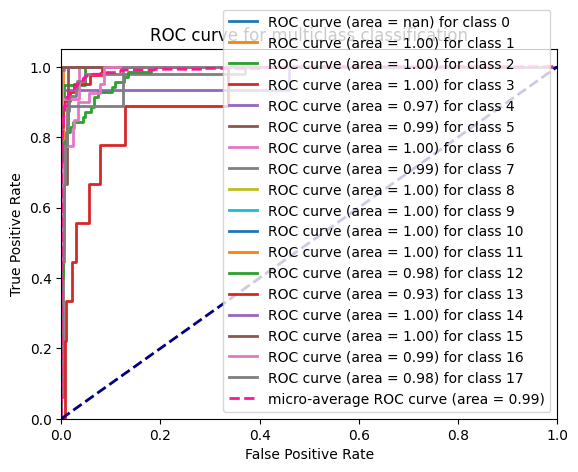

In [105]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
y_prob = torch.softmax(model(X_test), dim=1).detach().numpy()
# print(y_prob[])
fpr = dict()
tpr = dict()
roc_auc = dict()
print(np.unique(y))
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
print(y_test_bin.shape)
print(y_prob.shape)
for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
for i in range(y_test_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=lw, linestyle='--', label='micro-average ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for multiclass classification')
plt.legend(loc="lower right")
plt.show()